# Econ 1923 - Product Differentiation Project

## 1 Preparation
### 1.1 Obtaining the data
Create a data set containing nutrition information about cereal boxes. You can use all sources including the nutrition APIs, stores web pages, actual grocery stores, your pantry, etc.
At the end of this process, you should have a dataframe that contains as many cereal boxes as possible and for each, you should have several nutritional facts and (ideally) serving sizes (cups or grams).
The result of this part can be several dataframes, each resulting from the different data sources that you used.

Sources: Edemam API, GitHub JSON Files, personal cereals


In [113]:
#Importing packages
import requests, json, time
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
%run ../APIkeys.py

In [114]:
app_id = os.environ['EDAMAM_API_id']
key = os.environ['EDAMAM_API_key']
#baseURL = 'https://api.edamam.com/api/food-database/v2/parser?app_id='+app_id+'&app_key='+key+'&upc='
#endURL = '&nutrition-type=cooking&category=packaged-foods'

pd.set_option('display.max_rows', None, 'display.max_columns', None)

In [115]:
def checkUPC_edamam(upc):
    # This function is called checkUPC_V2 in previous notebooks
    
    edamam_id = os.environ['EDAMAM_API_id']
    edamam_key = os.environ['EDAMAM_API_key']
    edamam_baseURL = 'https://api.edamam.com/api/food-database/v2/parser?app_id='+edamam_id+'&app_key='+edamam_key+'&upc='
    edamam_endURL = '&nutrition-type=cooking&category=packaged-foods'
    url = edamam_baseURL + upc + edamam_endURL
    info = requests.get(url).json()
    if 'error' in info:
        return info
    else:
        answer = info['hints'][0]['food']['nutrients']
        
        sizeList = info['hints'][0]['food']['servingSizes']
        n = len(sizeList)
        for i in range(n):
            if sizeList[i]['label'] == 'Gram':
                answer['servingSize_gram'] = info['hints'][0]['food']['servingSizes'][i]['quantity']
            if sizeList[i]['label'] == 'Cup':
                answer['servingSize_cup'] = info['hints'][0]['food']['servingSizes'][i]['quantity']
        
        answer['label'] = info['hints'][0]['food']['label']
        answer['upc'] = upc
        return answer

In [116]:
#We add a 2 second interval between each call to stay under the limit for the Edamam API.

def multiUPC_edamam(shelf, verbose = False, leftovers = False, source=""):
    # This function is called multiUPC_V2 in previous notebooks
    
    # Shelf - a list of strings, each representing a UPC code
    # verbose - boolean telling the function whether to print found/unfound UPCs
    # leftovers - boolean telling the function whetehr to output the 
    
    found = []    #container for information on found UPCS
    unfound = []  #container for unfound UPCs
    
    # loop over UPCs in shelf
    for upc in shelf:
        info = checkUPC_edamam(upc)
        
        if 'error' in info:
            unfound.append(upc) #add to the unfound container
            if verbose:
                print('UPC ',upc, ' does not exist in the API\'s data base')
                time.sleep(2)
        
        else:
            if verbose:
                print('UPC ',upc, ' exists in the API\'s data base')
                time.sleep(2)
            found.append(info)
    
    # turn the dictionary found into a Dataframe
    if len(found)>0:
        df_found = pd.DataFrame(found)
    else:
        df_found = pd.DataFrame()
    
    # add a source column
    df_found["dataSource"] = pd.Series([source for i in range(len(df_found.index))])
    
    
    # return the values of found and unfound (optional)
    if leftovers:
        return df_found,unfound
    else:
        return df_found

In [117]:
#Get Whole Foods / Giant Eagle Cereals
url = "https://raw.githubusercontent.com/ArieBeresteanu/Econ-1923/main/Cereal_Project/cereal_WholeFoods.json"
response = json.loads(requests.get(url).text)

# skipping the first entry
WF_GE_DF = pd.DataFrame(response['cereal'])

# Getting the shape of the dataframe:
# n = number of rows (observations)
# c = number of columns
n,c = WF_GE_DF.shape

# names of columns
#WF_GE_DF.columns

In [118]:
# Save raw whole foods data to excel
WF_GE_DF.to_excel("WholeFoods_GiantEagle_Raw.xlsx", sheet_name='Cereal Data')

In [119]:
# rename columns
WF_GE_DF = WF_GE_DF.rename(columns={"ENERC_KCAL": "CALORIES", 
                              "Carb": "CARB", 
                              "Protein": "PROTEIN", 
                              "Iron": "IRON", 
                              "Calcium": "CALCIUM", 
                              "Fiber": "FIBER",
                              'VitB6A': 'VITB6A',
                              "FAMONO": "FATMONO"
                             })
WF_GE_DF['dataSource'] = 'GiantEagle / WholeFoods'
WF_GE_DF

,label,CALORIES,FAT,FASAT,FATRN,CHOLE,NA,CARB,FIBER,SUGAR,SUGAR.added,PROTEIN,VITD,P,IRON,CALCIUM,servingSize_cup,servingSize_Gram,FAPOLY,FATMONO,FOLAC,VITB6A,NIA,MG,dataSource
0,"Purely Elizabeth, Original Ancient Grain Grano...",130,6.0,3.5,0.0,0.0,135,19.0,2.0,7.0,7.0,3.0,0.0,117.0,1.00,14.0,0.333,30.0,NaN,NaN,NaN,NaN,NaN,NaN,GiantEagle / WholeFoods
1,"Catalina Crunch, Cinnamon Toast Cereal, 9 oz",110,5.0,0.5,0.0,0.0,110,14.0,9.0,0.0,0.0,11.0,0.0,30.0,1.60,50.0,NaN,36.0,NaN,NaN,NaN,NaN,NaN,NaN,GiantEagle / WholeFoods
2,"Catalina Crunch, Dark Chocolate Cereal, 9 oz",110,6.0,1.0,0.0,0.0,125,14.0,9.0,0.0,0.0,11.0,0.0,80.0,2.30,50.0,NaN,36.0,NaN,NaN,NaN,NaN,NaN,NaN,GiantEagle / WholeFoods
3,"Michele's Granola, Original Granola, 12 oz",150,9.0,2.0,0.0,0.0,0,15.0,2.0,6.0,5.0,3.0,0.0,110.0,1.00,20.0,0.250,28.0,NaN,NaN,NaN,NaN,NaN,NaN,GiantEagle / WholeFoods
4,"365 by Whole Foods Market, Organic Cereal, Oat...",240,7.0,0.5,0.0,0.0,50,40.0,3.0,15.0,15.0,5.0,0.0,150.0,1.50,30.0,0.500,55.0,2.0,4.0,NaN,NaN,NaN,NaN,GiantEagle / WholeFoods
5,"Nature's Path Organic, Heritage Flakes Cereal,...",160,1.5,0.0,0.0,0.0,170,31.0,7.0,5.0,5.0,5.0,0.0,197.0,2.00,0.0,1.000,40.0,NaN,NaN,NaN,NaN,NaN,NaN,GiantEagle / WholeFoods
6,"Cheerios Honey Nut , 15.4 oz",180,2.0,0.0,0.0,0.0,210,30.0,3.0,12.0,12.0,3.0,2.0,150.0,3.60,130.0,1.000,37.0,NaN,NaN,NaN,NaN,NaN,NaN,GiantEagle / WholeFoods
7,"Nature's Path Organic, Heritage Flakes Cereal,...",160,1.5,0.0,0.0,0.0,170,31.0,7.0,5.0,5.0,5.0,0.0,197.0,2.00,0.0,1.000,40.0,NaN,NaN,NaN,NaN,NaN,NaN,GiantEagle / WholeFoods
8,"Cascadian Farm, Organic Cinnamon Crunch Cereal...",180,3.0,0.0,0.0,0.0,140,29.0,3.0,11.0,11.0,2.0,0.0,0.0,1.00,0.0,1.000,36.0,NaN,NaN,NaN,NaN,NaN,NaN,GiantEagle / WholeFoods
9,"365 by Whole Foods Market, Granola Maple Almon...",260,9.0,1.0,0.0,0.0,115,38.0,4.0,11.0,10.0,7.0,0.0,21.0,1.80,60.0,0.667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GiantEagle / WholeFoods


In [100]:
#reading excel and csv files containing states' WIC 
#Approved Products Lists (APLs) and filtering down to cereal UPCs

df_IL = pd.read_excel('IL_WIC_APL.xlsx') #Illinois
df_IL = df_IL.drop([174], axis=0)
df_IL = df_IL.reset_index(drop=True)

df_MA = pd.read_excel('MA_WIC_APL.xlsx')
df_MA = df_MA[df_MA['Category Name']=='Breakfast Cereal'] #Massachusetts
df_MA = df_MA.reset_index(drop=True)

df_MN = pd.read_excel('MN_WIC_APL.xlsx')#Minnesota

df_NE = pd.read_excel('NE_WIC_APL.xlsx')#Nebraska

df_NV = pd.read_csv('NV_WIC_APL.csv')#Nevada

df_NY = pd.read_excel('NY_WIC_APL.xlsx')#New York S
df_NY = df_NY[df_NY['Category']=='Breakfast Cereal ']
df_NY = df_NY.reset_index(drop=True)

In [101]:
#Isolating UPCs into string arrays and combining
IL_UPCs = []
for i in range(0,len(df_IL['UPC/PLU Code'])-1):
    IL_UPCs.append(df_IL['UPC/PLU Code'][i][7:18])
    
MA_UPCs = []
for i in range(0,len(df_MA['UPC'])-1):
    MA_UPCs.append(str(df_MA['UPC'][i]))

MN_UPCs = []
for i in range(0,len(df_MN['UPC_PLU'])-1):
    MN_UPCs.append(str(df_MN['UPC_PLU'][i]))
    
NE_UPCs = []
for i in range(0,len(df_NE['UPC'])-1):
    NE_UPCs.append(str(df_NE['UPC'][i]))

NV_UPCs = []
for i in range(0,len(df_NV['UPC'])-1):
    if len(df_NV['UPC'][i])==14:
        NV_UPCs.append(df_NV['UPC'][i][2:13])
    elif len(df_NV['UPC'][i])==15:
        NV_UPCs.append(df_NV['UPC'][i][3:14])

NY_UPCs = []
for i in range(0,len(df_NY['UPC/PLU Number'])-1):
    if len(str(df_NY['UPC/PLU Number'][i]))==11:
        NY_UPCs.append(str(df_NY['UPC/PLU Number'][i]))
    elif len(str(df_NY['UPC/PLU Number'][i]))==12:
        NY_UPCs.append(str(df_NY['UPC/PLU Number'][i])[1:12])
        
UPCs = IL_UPCs + MA_UPCs + MN_UPCs + NE_UPCs + NV_UPCs + NY_UPCs #combining
UPCs = list(set(UPCs)) #removes duplicate UPCs, and then coerces into a list

In [102]:
found, unfound = multiUPC_edamam(UPCs, verbose = True, leftovers = True, source="Edamam_API")

UPC  38000202117  exists in the API's data base
UPC  688267070495  exists in the API's data base
UPC  41190033294  exists in the API's data base
UPC  41268202676  exists in the API's data base
UPC  16000170117  does not exist in the API's data base
UPC  11225124099  exists in the API's data base
UPC  41190065004  exists in the API's data base
UPC  16000264243  exists in the API's data base
UPC  41268208388  exists in the API's data base
UPC  84912320445  does not exist in the API's data base
UPC  70038606925  does not exist in the API's data base
UPC  42187541655  does not exist in the API's data base
UPC  688267155758  exists in the API's data base
UPC  18894110545  exists in the API's data base
UPC  16000487697  exists in the API's data base
UPC  36800110113  exists in the API's data base
UPC  884912249265  exists in the API's data base
UPC  884912006806  exists in the API's data base
UPC  11110810106  exists in the API's data base
UPC  11110878243  exists in the API's data base
UPC 

UPC  16000142442  does not exist in the API's data base
UPC  79166933064  does not exist in the API's data base
UPC  84912249265  does not exist in the API's data base
UPC  78742147048  exists in the API's data base
UPC  41735010179  exists in the API's data base
UPC  11161018377  exists in the API's data base
UPC  21130280193  exists in the API's data base
UPC  16000401051  exists in the API's data base
UPC  492310003206  exists in the API's data base
UPC  99771333041  does not exist in the API's data base
UPC  73296066104  does not exist in the API's data base
UPC  41303042311  exists in the API's data base
UPC  78742075648  exists in the API's data base
UPC  41735022103  does not exist in the API's data base
UPC  688267064517  exists in the API's data base
UPC  41268203642  does not exist in the API's data base
UPC  16000658509  exists in the API's data base
UPC  41303046319  exists in the API's data base
UPC  84912356178  does not exist in the API's data base
UPC  72400060182  exis

UPC  93476000145  does not exist in the API's data base
UPC  78742122083  exists in the API's data base
UPC  50700561240  exists in the API's data base
UPC  38000200663  exists in the API's data base
UPC  64144080304  exists in the API's data base
UPC  41303001790  exists in the API's data base
UPC  02185904601  does not exist in the API's data base
UPC  11110833037  exists in the API's data base
UPC  13130006965  exists in the API's data base
UPC  11110810113  exists in the API's data base
UPC  41735158420  does not exist in the API's data base
UPC  21333061087  exists in the API's data base
UPC  41268164219  exists in the API's data base
UPC  77890375761  exists in the API's data base
UPC  70253298424  exists in the API's data base
UPC  884912001870  exists in the API's data base
UPC  70253298790  exists in the API's data base
UPC  16000168756  does not exist in the API's data base
UPC  41190033287  exists in the API's data base
UPC  84912356291  does not exist in the API's data base

UPC  42400026815  exists in the API's data base
UPC  49705010044  exists in the API's data base
UPC  35826074997  exists in the API's data base
UPC  49705005460  exists in the API's data base
UPC  16000170032  does not exist in the API's data base
UPC  16000275492  exists in the API's data base
UPC  88267155758  does not exist in the API's data base
UPC  16000103719  exists in the API's data base
UPC  70784471648  does not exist in the API's data base
UPC  16000666603  exists in the API's data base
UPC  43000105405  exists in the API's data base
UPC  41268108336  exists in the API's data base
UPC  16000488366  exists in the API's data base
UPC  41190751228  exists in the API's data base
UPC  84912105107  does not exist in the API's data base
UPC  725439109895  exists in the API's data base
UPC  91669199104  does not exist in the API's data base
UPC  18894115410  does not exist in the API's data base
UPC  30000560839  exists in the API's data base
UPC  30000064429  exists in the API's d

UPC  41270813563  exists in the API's data base
UPC  16000625709  exists in the API's data base
UPC  75450127942  exists in the API's data base
UPC  35826100115  does not exist in the API's data base
UPC  884912249272  exists in the API's data base
UPC  42400084778  exists in the API's data base
UPC  38000199509  exists in the API's data base
UPC  38000596674  exists in the API's data base
UPC  41318290189  exists in the API's data base
UPC  50700561196  exists in the API's data base
UPC  24300031625  exists in the API's data base
UPC  70038342878  does not exist in the API's data base
UPC  688267064524  exists in the API's data base
UPC  42187408989  does not exist in the API's data base
UPC  41497530052  exists in the API's data base
UPC  38000200038  exists in the API's data base
UPC  84912014290  does not exist in the API's data base
UPC  49705005545  does not exist in the API's data base
UPC  98487952356  exists in the API's data base
UPC  50700561288  does not exist in the API's 

UPC  884912004710  exists in the API's data base
UPC  38000198823  does not exist in the API's data base
UPC  83921118999  does not exist in the API's data base
UPC  41190046775  exists in the API's data base
UPC  11153041901  exists in the API's data base
UPC  41497537310  exists in the API's data base
UPC  11225024603  exists in the API's data base
UPC  41735088604  does not exist in the API's data base
UPC  11225124044  exists in the API's data base
UPC  70038639985  exists in the API's data base
UPC  75130414072  exists in the API's data base
UPC  688267065316  exists in the API's data base
UPC  70038304821  exists in the API's data base
UPC  70784472652  exists in the API's data base
UPC  11153041857  does not exist in the API's data base
UPC  35882007010  does not exist in the API's data base
UPC  41303001783  exists in the API's data base
UPC  42400146322  exists in the API's data base
UPC  38000269967  does not exist in the API's data base
UPC  38000202124  does not exist in th

UPC  38000198410  exists in the API's data base
UPC  70253280290  exists in the API's data base
UPC  42400055075  does not exist in the API's data base
UPC  91669300388  does not exist in the API's data base
UPC  884912012784  exists in the API's data base
UPC  21859046209  exists in the API's data base
UPC  688267135750  exists in the API's data base
UPC  21130280490  exists in the API's data base
UPC  11110853110  exists in the API's data base
UPC  70784471983  exists in the API's data base
UPC  36800110175  exists in the API's data base
UPC  11110907585  does not exist in the API's data base
UPC  41270040914  exists in the API's data base
UPC  11110809414  exists in the API's data base
UPC  13733914000  does not exist in the API's data base
UPC  725439103091  exists in the API's data base
UPC  42187001500  does not exist in the API's data base
UPC  91669301224  does not exist in the API's data base
UPC  42400142997  exists in the API's data base
UPC  20794011760  does not exist in t

In [103]:
Found = pd.DataFrame(found)
Missing = pd.DataFrame(unfound)
print('There are ', len(Missing), ' missing UPCs.')
print('There are ', len(Found), ' found UPCs.')

There are  341  missing UPCs.
There are  690  found UPCs.


In [104]:
# Save raw data from Excel before making any changes
Found.to_excel("edamam_Raw.xlsx", sheet_name='Cereal Data')
Found

,ENERC_KCAL,FAT,FASAT,FATRN,FAMS,FAPU,CHOCDF,FIBTG,SUGAR,SUGAR.added,PROCNT,CHOLE,NA,CA,MG,K,FE,ZN,P,THIA,NIA,FOLAC,servingSize_gram,servingSize_cup,label,upc,VITC,RIBF,VITB6A,VITB12,VITD,Sugar.alcohol,TOCPHA,VITK1,WATER,dataSource
0,339.000000,1.790000,0.000000,0.0,0.000000,0.000000,83.930000,10.700000,19.639999,19.600000,8.930000,0.000000,18.000000,18.000000,71.000000,357.000000,32.139999,2.680000,179.000000,0.000000,3.571000,420.000000,56.000000,1.000000,Original Frosted Mini Wheats Whole Grain Cerea...,38000202117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Edamam_API
1,352.739619,0.000000,0.000000,0.0,0.000000,0.000000,84.657509,3.527396,7.054792,NaN,7.054792,0.000000,705.479239,NaN,NaN,88.184905,31.746566,NaN,NaN,1.340411,17.636981,352.739619,NaN,1.000000,"Giant Cereal Corn Flakes, 18.0 Oz",688267070495,52.910943,1.516780,1.763698,5.291094,3.527396,NaN,NaN,NaN,NaN,Edamam_API
2,357.000000,0.000000,0.000000,0.0,0.000000,0.000000,85.709999,3.600000,7.140000,NaN,7.140000,0.000000,571.000000,0.000000,NaN,2250.000000,32.139999,NaN,NaN,1.000000,17.857000,NaN,28.000000,1.000000,"Shoprite, Corn Flakes Cereal",41190033294,53.599998,1.518000,1.786000,5.360000,NaN,NaN,NaN,NaN,NaN,Edamam_API
3,345.000000,1.820000,0.000000,0.0,0.000000,0.910000,83.639999,9.100000,20.000000,NaN,9.090000,0.000000,0.000000,0.000000,73.000000,327.000000,29.450001,2.730000,273.000000,1.000000,9.091000,NaN,55.000000,1.250000,"Hannaford, Whole Grain Wheat Cereal, Strawberr...",41268202676,0.000000,0.773000,0.909000,2.730000,NaN,NaN,NaN,NaN,NaN,Edamam_API
4,406.000000,0.000000,0.000000,0.0,0.000000,0.000000,87.500000,3.100000,6.250000,NaN,6.250000,0.000000,562.000000,0.000000,NaN,172.000000,28.120001,NaN,NaN,1.000000,15.625000,NaN,32.000000,1.000000,Corn Flakes Cereal,11225124099,46.900002,1.328000,1.562000,4.690000,NaN,NaN,NaN,NaN,NaN,Edamam_API
5,366.000000,6.100000,0.000000,0.0,2.440000,2.440000,73.169998,7.300000,0.000000,NaN,12.200000,0.000000,488.000000,610.000000,98.000000,341.000000,19.760000,9.150000,366.000000,2.000000,7.317000,61.000000,41.000000,NaN,Toasted Whole Grain Oat Cereal,41190065004,NaN,NaN,0.732000,NaN,NaN,NaN,NaN,NaN,NaN,Edamam_API
6,357.142857,7.142857,0.000000,0.0,NaN,NaN,71.428571,10.714286,3.571429,NaN,10.714286,0.000000,500.000000,357.142857,142.857143,607.142857,28.928573,13.392857,357.142857,1.357143,17.857143,714.285714,28.000000,1.000000,"Cheerios Cereal Double Pack, 2.0 Ea",16000264243,21.428571,1.535714,1.785714,5.357143,3.571429,NaN,NaN,NaN,NaN,Edamam_API
7,381.000000,4.760000,0.000000,0.0,NaN,NaN,78.570000,7.100000,19.049999,19.000000,9.520000,0.000000,548.000000,405.000000,NaN,262.000000,12.860000,4.050000,310.000000,2.000000,4.762000,60.000000,42.000000,1.000000,Easy Living Oat Squares Cereal,41268208388,NaN,NaN,0.714000,NaN,NaN,NaN,NaN,NaN,NaN,Edamam_API
8,67.628045,0.845351,0.000000,0.0,0.000000,0.281784,14.089176,1.127134,3.381402,NaN,1.690701,0.000000,78.899386,56.356705,NaN,84.535057,5.072103,2.113376,56.356705,0.214155,2.817835,135.256091,NaN,0.750000,Ahold Oven-Toasted Cereal Oat Squares,688267155758,NaN,0.242334,0.281784,NaN,NaN,NaN,NaN,NaN,NaN,Edamam_API
9,394.000000,0.000000,0.000000,0.0,0.000000,0.000000,87.879997,0.000000,12.120000,NaN,9.090000,0.000000,545.000000,0.000000,24.000000,167.000000,27.270000,11.360000,121.000000,1.000000,18.181999,NaN,33.000000,1.250000,"Toasted Crisp Rice Cereal, Toasted",18894110545,45.500000,1.545000,1.515000,4.550000,NaN,NaN,NaN,NaN,NaN,Edamam_API


In [106]:
#df = df.reset_index()  # make sure indexes pair with number of rows
Missing_UPCs = []
for row in Missing.itertuples():
    Missing_UPCs.append(row[1])
Missing_UPCs

['16000170117',
 '84912320445',
 '70038606925',
 '42187541655',
 '17544126904',
 '88267169793',
 '41270830775',
 '884912359155',
 '49705017883',
 '16000183728',
 '50700031897',
 '42400178002',
 '93476000282',
 '51933342637',
 '38000198809',
 '21333060615',
 '38000198656',
 '41270019743',
 '88267090998',
 '84912003911',
 '99771333102',
 '42187425313',
 '16000161672',
 '11110876003',
 '884912359162',
 '3811009',
 '30000571132',
 '21130280865',
 '41268155828',
 '41270830799',
 '16000178182',
 '50700213712',
 '35826074973',
 '30000570241',
 '49705105405',
 '16000169623',
 '70038604204',
 '84912259363',
 '50700200682',
 '88267078729',
 '93476000183',
 '41497530441',
 '88267090981',
 '50700742960',
 '13733913997',
 '38000198458',
 '884912356291',
 '38000231537',
 '73296034516',
 '42187408750',
 '16000142442',
 '79166933064',
 '84912249265',
 '99771333041',
 '73296066104',
 '41735022103',
 '41268203642',
 '84912356178',
 '622261091001',
 '23627050142',
 '38527135325',
 '84912359155',
 '497050

In [107]:
my_id = os.environ["NUTRITIONIX_API_id"]
my_key = os.environ["NUTRITIONIX_API_key"]

baseURL = "https://trackapi.nutritionix.com/v2/search/item?upc="

HEADERS = {
    "x-app-id" : my_id,
    "x-app-key" : my_key,
    "Content-Type" : "application/json"
}

In [108]:
def inquiry(upc,source=""):
    try:        
        url = nutritionix_baseURL+upc
        r = requests.get(url, headers=nutritionix_HEADERS).json()
        r2 = r["foods"][0]
        r2["UPC"]  = upc
        r2["source"] = source
        return r2
    except:
        return "UPC could not be found"

In [109]:
def translate_N2E(d):
    #this function gets a reply from Nutrtionix API in a form of a dictionary 
    # and translates it into a dictionary in the form of Edamam's API

    iron = None
    ca = None
    trans = None
    vitd = None
    sugr_ad = None
    lb = d["brand_name"] + ", " + d["food_name"]
    
    for dd in d["full_nutrients"]:
        attr_id = dd["attr_id"]
        val = dd["value"]
        if attr_id == 303:
            iron = val        
        elif attr_id == 301:
            ca = val
        elif attr_id == 605:
            trans = val
        elif attr_id == 324:
            vitd = val
        elif attr_id == 539:
            sugr_ad = val
        
    new_d = {
        "label" : lb,
        "ENERC_KCAL" : d["nf_calories"],
        "FAT" : d["nf_total_fat"],
        "FASAT" : d["nf_saturated_fat"],
        "FATRN" : trans,
        "CHOLE" : d["nf_cholesterol"],
        "NA" : d["nf_sodium"],
        "CHOCDF" : d["nf_total_carbohydrate"],
        "FIBTG" : d["nf_dietary_fiber"],
        "SUGAR" : d["nf_sugars"],
        "SUGAR.added" : sugr_ad,
        "PROCNT" : d["nf_protein"],
        "VITD" : vitd,
        "P" : d["nf_potassium"],
        "FE" : iron,
        "CA" : ca,
        "servingSize_cup" : d["serving_qty"],
        "servingSize_gram" : d["serving_weight_grams"],
        "upc" : d["UPC"],
        "dataSource" : d["source"]
        }
    
    return new_d

In [110]:
#Used up Nutrix calls with debugging

""""
frames = []
for i in range(1):
    check = inquiry(Missing_UPCs[0]) # Already checked 0-
    if check == "UPC could not be found":
        print(check)
    else:
        dict_edamam = translate_N2E(check)
        frames.append(dict_edamam)
nutrix_found = pd.concat(frames)
""

SyntaxError: EOF while scanning triple-quoted string literal (Temp/ipykernel_35272/3040992223.py, line 13)

In [111]:
'''
#The dataframe appears to still have some duplicate cereal labels, so we're dropping them
Found = Found.drop_duplicates(subset=['label'],keep='last')

#Add source column and fill with 
Found['Source'] = 'EDAMAM_API'

#Since calling all the UPCs takes a long time, we're saving the 
#dataframe into an excel sheet for quicker loader later on
Found.to_excel("Ed.xlsx", sheet_name='Cereal Data')
'''

'\n#The dataframe appears to still have some duplicate cereal labels, so we\'re dropping them\nFound = Found.drop_duplicates(subset=[\'label\'],keep=\'last\')\n\n#Add source column and fill with \nFound[\'Source\'] = \'EDAMAM_API\'\n\n#Since calling all the UPCs takes a long time, we\'re saving the \n#dataframe into an excel sheet for quicker loader later on\nFound.to_excel("Ed.xlsx", sheet_name=\'Cereal Data\')\n'

### 1.2 Cleaning and re-scaling
Various data sources may contain different variable names, different units, or different serving sizes. Also, missing values can be an issue. Here, you are asked to:
- Make sure that variable names in all dataframes that you created match.
- Make sure that all nutritional measurements in all data frames are the same (e.g. per cup or per 100gr).
- Merge the different data sources.
 
The final data set should include a column indicating the source of the observation (i.e. is it from the API, entered manually from a certain store, etc.).

In [123]:
# rename columns
Found = Found.rename(columns={"ENERC_KCAL": "CALORIES",
                              "CHOCDF": "CARB", 
                              "PROCNT": "PROTEIN", 
                              "FE": "IRON", 
                              "CA": "CALCIUM", 
                              "FIBTG": "FIBER",
                              "FAPU": "FAPOLY",
                              "FAMS": "FATMONO"
                             })
Found = Found.drop(columns=['WATER', 'VITK1', 'TOCPHA', 'RIBF', 'VITB12', 'Sugar.alcohol', 'VITC', 'THIA', 'ZN', 'K'])

In [140]:
#Concat WholeFoods_GiantEagle Data with data from Edamam API
Nutrition_df = pd.concat([Found, WF_GE_DF], axis=0, ignore_index=True)
Nutrition_df

#remove duplicates
Nutrition_df = Nutrition_df.drop_duplicates(subset=['label'],keep='last')

# Save combined data to Excel to read from
Nutrition_df.to_excel("Cereal_Nutrition.xlsx", sheet_name='Cereal Data')

In [141]:
Cereals_df = pd.read_excel('Cereal_Nutrition.xlsx')
len(Cereals_df['label'])

#Cereals

609

### 1.3 Descriptive statistics
Create a table with descriptive statistics (Mean, Median, standard deviation, range, number of missing observations, etc.

In [142]:
Cereals_df.describe()


,Unnamed: 0,CALORIES,FAT,FASAT,FATRN,FATMONO,FAPOLY,CARB,FIBER,SUGAR,SUGAR.added,PROTEIN,CHOLE,NA,CALCIUM,MG,IRON,P,NIA,FOLAC,servingSize_gram,servingSize_cup,upc,VITB6A,VITD,servingSize_Gram
count,609.000000,609.000000,606.000000,590.000000,596.0,320.000000,323.000000,609.000000,606.000000,601.000000,165.000000,609.000000,585.000000,608.000000,493.000000,295.000000,546.000000,414.000000,434.000000,218.000000,499.000000,476.000000,5.350000e+02,414.000000,198.000000,73.000000
mean,404.366174,337.780980,2.963560,0.179434,0.0,0.841533,0.920939,73.198757,7.270172,10.871023,12.162424,8.530505,0.058019,392.667647,154.291895,87.495850,24.274699,252.916276,15.404002,1299.973973,38.723835,0.901953,9.406952e+10,1.671906,2.315729,43.557534
std,223.906786,79.475219,2.650944,0.676768,0.0,1.306884,0.803420,19.507452,4.823023,7.631822,6.607612,3.453061,0.992195,279.289555,242.132545,44.768445,13.082001,153.948644,12.036307,12955.916132,11.805315,0.329494,1.880423e+11,1.352431,2.813532,12.009833
min,0.000000,40.576827,0.000000,0.000000,0.0,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.250000,1.600028e+09,0.000000,0.000000,27.000000
25%,213.000000,345.000000,1.014172,0.000000,0.0,0.000000,0.000000,74.075320,3.300000,3.571429,7.000000,6.670000,0.000000,110.000000,0.000000,56.219170,16.017500,133.000000,9.091000,190.202740,29.000000,0.750000,2.133306e+10,0.938285,0.000000,35.000000
50%,414.000000,358.691755,2.027827,0.000000,0.0,0.000000,0.910000,80.000000,7.100000,10.000000,11.000000,8.330000,0.000000,432.719684,35.273962,80.000000,28.462438,254.815391,15.625000,358.000000,32.000000,1.000000,4.127004e+10,1.562000,1.742190,40.000000
75%,603.000000,381.000000,4.990100,0.000000,0.0,1.790000,1.670000,84.379997,10.344828,18.750000,18.299999,10.344828,0.000000,571.428571,326.000000,114.060822,30.000000,333.000000,17.636981,665.346697,51.000000,1.000000,7.078447e+10,1.763698,3.527396,55.000000
max,764.000000,436.000000,15.000000,8.000000,0.0,6.670000,2.860000,110.000000,45.725504,32.142857,26.700001,31.250000,17.636981,1484.151949,3527.396195,323.000000,63.493132,1129.000000,70.547924,191667.000000,63.000000,5.500000,8.849124e+11,7.054792,8.818490,65.000000


## 2 Market Analysis
### 2.1 Visualisation
Create scatter plots of the data. Here you have to try several pairs of characteristics on which it seems like the products are more differentiated. This is a visual exercise but you can support your claims by looking at standard deviations and correlations.

In [143]:
#making a short list of nutrition facts (you can make your own!)

nutrition_facts = ['CALORIES', 
                   'FAT', 
                   'NA', 
                   'CARB', 
                   'FIBER', 
                   'SUGAR', 
                   'SUGAR.added', 
                   'PROTEIN', 
                   'P', 
                   'IRON', 
                   'CALCIUM', 
                   'MG',
                   'CHOLE',
                   'NIA',
                   'FOLAC',
                   'VITD'
                  ]

Correlation matrix

In [144]:
Cereals_df[nutrition_facts].corr()

,CALORIES,FAT,NA,CARB,FIBER,SUGAR,SUGAR.added,PROTEIN,P,IRON,CALCIUM,MG,CHOLE,NIA,FOLAC,VITD
CALORIES,1.000000,-0.008814,0.421475,0.904863,0.166681,0.226725,0.692415,0.468216,0.258285,0.605256,0.183123,-0.081861,0.013769,0.000161,0.018209,0.565180
FAT,-0.008814,1.000000,-0.190202,-0.265662,0.220430,0.087984,-0.183237,0.132362,0.118897,-0.242866,0.047266,0.179121,-0.010084,-0.059122,-0.027457,-0.157071
NA,0.421475,-0.190202,1.000000,0.417807,-0.124407,-0.146805,0.019788,0.100369,0.200376,0.485717,0.349623,0.104115,0.061231,0.355288,-0.082770,0.592522
CARB,0.904863,-0.265662,0.417807,1.000000,0.206046,0.263204,0.691666,0.325419,0.304525,0.681727,0.121396,-0.065006,0.019100,0.123498,0.044753,0.602641
FIBER,0.166681,0.220430,-0.124407,0.206046,1.000000,0.165780,0.468127,0.456191,0.715326,0.275817,0.061974,0.688666,0.035698,0.212440,0.034740,0.225765
SUGAR,0.226725,0.087984,-0.146805,0.263204,0.165780,1.000000,0.975422,-0.029121,-0.005127,0.273058,-0.222671,-0.266699,0.008753,0.082945,0.069966,0.323677
SUGAR.added,0.692415,-0.183237,0.019788,0.691666,0.468127,0.975422,1.000000,0.300792,0.367278,0.610317,-0.017049,-0.012540,NaN,-0.249425,0.078620,0.099615
PROTEIN,0.468216,0.132362,0.100369,0.325419,0.456191,-0.029121,0.300792,1.000000,0.450719,0.307577,0.165570,0.533920,0.002947,0.047600,-0.011699,0.273632
P,0.258285,0.118897,0.200376,0.304525,0.715326,-0.005127,0.367278,0.450719,1.000000,0.395294,0.256461,0.818925,0.145786,0.299326,0.023084,0.489913
IRON,0.605256,-0.242866,0.485717,0.681727,0.275817,0.273058,0.610317,0.307577,0.395294,1.000000,0.237318,0.208046,0.016237,0.758798,0.038430,0.730039


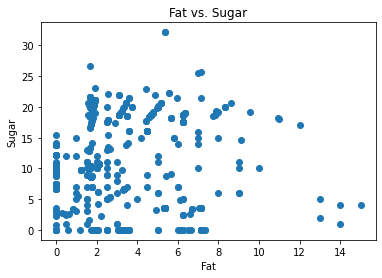

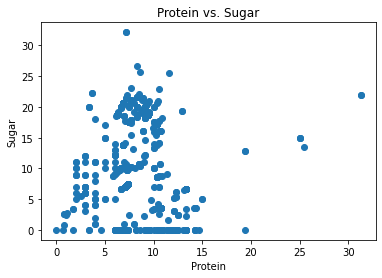

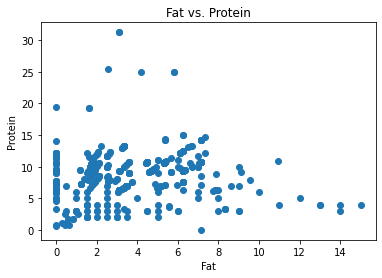

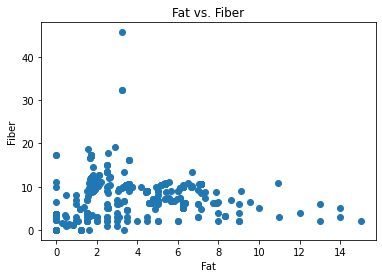

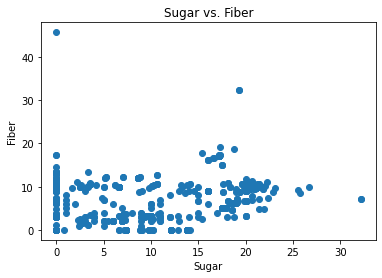

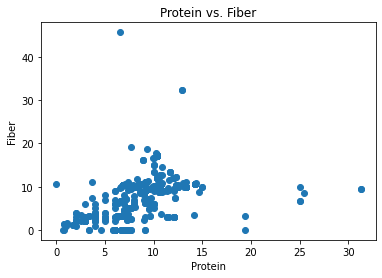

In [145]:
plt.scatter(Cereals_df['FAT'], Cereals_df['SUGAR'])
plt.title("Fat vs. Sugar")
plt.xlabel("Fat")
plt.ylabel("Sugar")
plt.show()

plt.scatter(Cereals_df['PROTEIN'], Cereals_df['SUGAR'])
plt.title("Protein vs. Sugar")
plt.xlabel("Protein")
plt.ylabel("Sugar")
plt.show()

plt.scatter(Cereals_df['FAT'], Cereals_df['PROTEIN'])
plt.title("Fat vs. Protein")
plt.xlabel("Fat")
plt.ylabel("Protein")
plt.show()

plt.scatter(Cereals_df['FAT'], Cereals_df['FIBER'])
plt.title("Fat vs. Fiber")
plt.xlabel("Fat")
plt.ylabel("Fiber")
plt.show()

plt.scatter(Cereals_df['SUGAR'], Cereals_df['FIBER'])
plt.title("Sugar vs. Fiber")
plt.xlabel("Sugar")
plt.ylabel("Fiber")
plt.show()

plt.scatter(Cereals_df['PROTEIN'], Cereals_df['FIBER'])
plt.title("Protein vs. Fiber")
plt.xlabel("Protein")
plt.ylabel("Fiber")
plt.show()

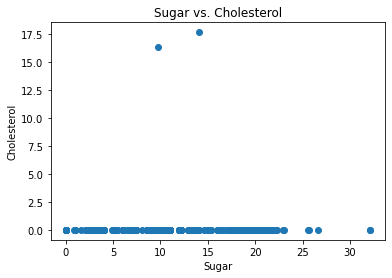

In [146]:
# From the correlation matrix Sugar v. Cholesterol looked very uncorrelated, 
# but there are some extreme outliers, so I'm not going to use it.  
plt.scatter(Cereals_df['SUGAR'], Cereals_df['CHOLE'])
plt.title("Sugar vs. Cholesterol")
plt.xlabel("Sugar")
plt.ylabel("Cholesterol")
plt.show()

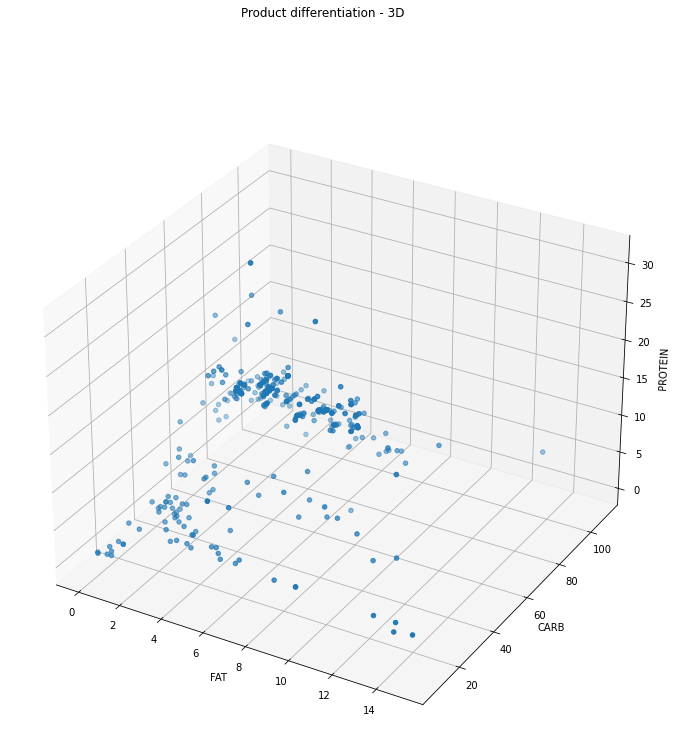

In [148]:
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection ="3d")

ax.scatter( Cereals_df['FAT'], Cereals_df['CARB'],Cereals_df['PROTEIN'])

ax.set_xlabel('FAT')
ax.set_ylabel('CARB')
ax.set_zlabel('PROTEIN')

fig.suptitle('Product differentiation - 3D')
plt.show()

### 2.2 K-Means clustering
Using the K-means clustering technique analyze the degree of product differentiation. Based on descriptive statistics, data availability, and scatter plots, choose pairs of features (i.e., nutrition facts) on which you believe the sellers differentiate themselves. Quantify your answer. You should try different K parameters. Report the goodness of fit (total sum of errors). *Instead of different pairs of features you can focus on the same pair and compare different locations or different supermarkets.*

In [155]:
#Replace NaN with 0 for Nutrition Columns
cols = ['CALORIES', 'FAT', 'NA', 'CARB', 'FIBER', 'SUGAR', 'SUGAR.added', 'PROTEIN', 'P', 'IRON', 'CALCIUM', 'MG', 'CHOLE', 'NIA', 'FOLAC', 'VITD']
for col in cols:
    Cereals_df[col] = Cereals_df[col].fillna(0)

In [163]:
features = ['PROTEIN','SUGAR']

#Create new data frame to PROTEIN and SUGAR with
selected_columns = Cereals_df[features]
ProSug_df = selected_columns.copy()

k = 4 #more on how to choose k appears later in this notebook

kmeans = KMeans(n_clusters=k, init='k-means++', random_state=0).fit(ProSug_df[features])
# Note:  K-means++ is a version of K-means algorithm which is more efficient

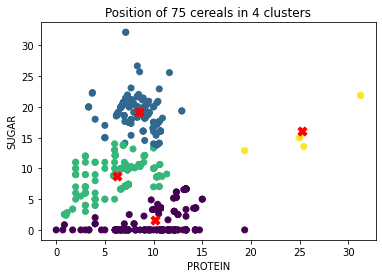

In [164]:
#scatter plot for the dataset
plt.scatter(data=Cereals_df, x=features[0], y=features[1],c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],marker="X", c="r", s=80, label="centroids")
plt.title(f"Position of {n} cereals in {k} clusters")
plt.xlabel(features[0])
plt.ylabel(features[1])
plt.show()

Looking carefully at the scatter plot above, it seems like the K means algorithm made very odd choices about classification! Some of the points seem to be placed in the wrong cluster. Specifically, it looks like the classification was made solely based on the _Energy_ element.

The reason for this is that the sacale of _Energy_ is about 100 fold bigger, so it influences the distance to the centroid much more than _Fat_.

Rescaling of a variable $x$ is done in the following way:
$$\frac{x -min(x)}{max(x)-min(x)} .$$

In [158]:
print(f"The inertia measure for k={k} is {kmeans.inertia_}")

The inertia measure for k=4 is 6974.027015544559


In [169]:
# Trying k=1..12

inertia = []
n_clusters = []
for i in range(1,13):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0).fit(ProSug_df[features])
    inertia.append(kmeans.inertia_)
    n_clusters.append(i)
    

C:\Users\Joshua\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


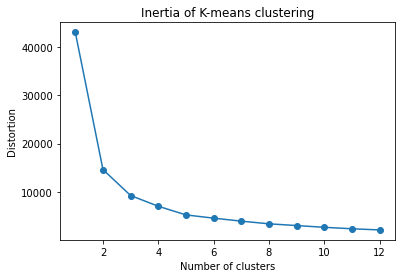

In [170]:
plt.plot(n_clusters,inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title("Inertia of K-means clustering")
plt.show()

## 3 Conclusions
Summarize your findings and draw conclusions from them. What can you recommend to cereal producers on the market? Do you find this market to be saturated? Here, I leave it to you to analyze your findings as you see fit. Given all the effort you have put, This section should be as very important.